In [1]:
import pandas as pd
import geopandas as gpd
from pyrosm import OSM
import shapely
from shapely.ops import polygonize
from shapely.ops import polygonize_full
import osmnx as ox

In [2]:
osm_data_pbf = "aubagne.pbf"
osm = OSM(osm_data_pbf)
vpied = osm.get_network(network_type="walking")

/home/patgendre/miniconda3/envs/omi/lib/python3.8/site-packages/pyrosm/networks.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nodes, ways, relation_ways, relations = get_osm_data(node_arrays=None,


<AxesSubplot:>

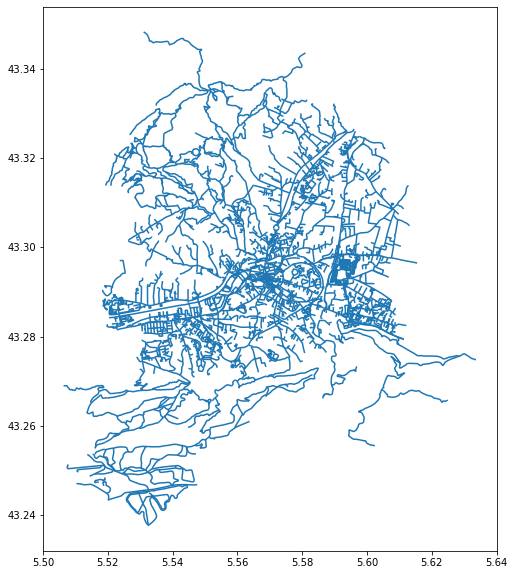

In [3]:
vpied.plot(figsize=(10,10))

In [6]:
vpied.columns
# pas mal de tags, par exemple surface ou lit est intéressant

Index(['access', 'bicycle', 'bridge', 'busway', 'cycleway', 'foot', 'footway',
       'highway', 'junction', 'lanes', 'lit', 'maxspeed', 'motorcar',
       'motor_vehicle', 'name', 'oneway', 'psv', 'ref', 'service',
       'segregated', 'sidewalk', 'surface', 'tracktype', 'tunnel', 'width',
       'id', 'timestamp', 'version', 'tags', 'geometry', 'osm_type'],
      dtype='object')

In [7]:
vpied[['foot','surface','tags','id','geometry','osm_type']]

foot  surface                                               tags  \
0     None  asphalt                                               None   
1     None     None                                               None   
2     None  asphalt  {"cycleway:right":"no","source:maxspeed":"FR:u...   
3     None  asphalt  {"cycleway:both":"no","embankment":"right","so...   
4     None  asphalt                         {"source:maxspeed":"sign"}   
...    ...      ...                                                ...   
3387  None     None                                               None   
3388  None     None                                               None   
3389  None     None                                               None   
3390  None     None                                               None   
3391  None     None                                               None   

             id                                           geometry osm_type  
0       3617343  LINESTRING (5.59457 43.32271, 5.59464 43.32291...      way  
1       3617344  LINESTRING (5.59485 43.31917, 5.59488 43.31924...      way  
2       3617355    LINESTRING (5.58376 43.29643, 5.58353 43.29640)      way  
3       3617356  LINESTRING (5.58899 43.29772, 5.58916 43.29780...      way  
4       3617357  LINESTRING (5.59687 43.29836, 5.59673 43.29837...      way  
...         ...                                                ...      ...  
3387  815006785    LINESTRING (5.57217 43.29237, 5.57216 43.29231)      way  
3388  815006786  LINESTRING (5.57226 43.29236, 5.57230 43.29236...      way  
3389  815006787  LINESTRING (5.57214 43.29228, 5.57206 43.29223...      way  
3390  815006788    LINESTRING (5.57162 43.29231, 5.57199 43.29216)      way  
3391  815006789  LINESTRING (5.57139 43.29246, 5.57143 43.29242...      way  

[3392 rows x 6 columns]

In [8]:
result, dangles, cuts, invalids = polygonize_full(vpied.geometry)

In [9]:
blocks=list(result)
invalidways=list(invalids)
cutways=list(cuts)
dangleways=list(dangles)
print(len(blocks),len(dangleways),len(cutways),len(invalidways))

172 114 2603 2


In [11]:
gdf = gpd.GeoDataFrame(pd.DataFrame(range(172)), geometry=blocks)

<AxesSubplot:>

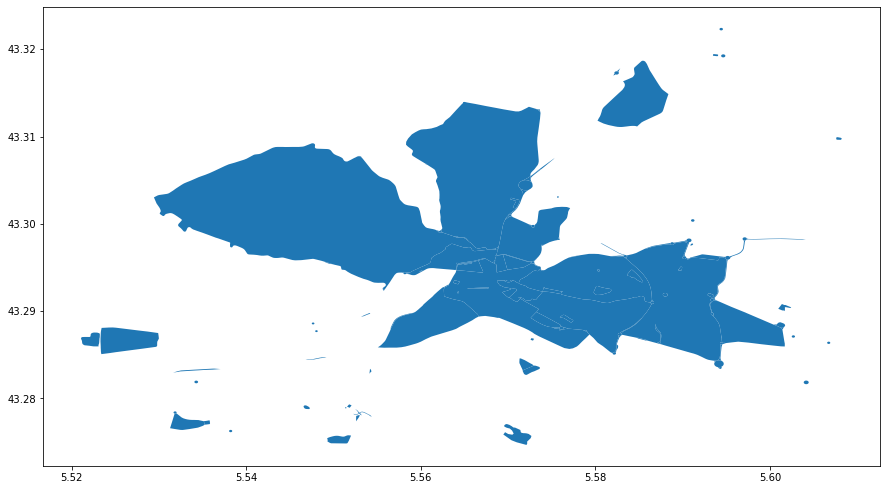

In [12]:
gdf.plot(figsize=(15,15))

In [ ]:
# pyrosm ne nettoie pas la topologie donc les polygones détectés sont incomplets

In [18]:
G = ox.graph_from_place('Aubagne, France',network_type='walk')

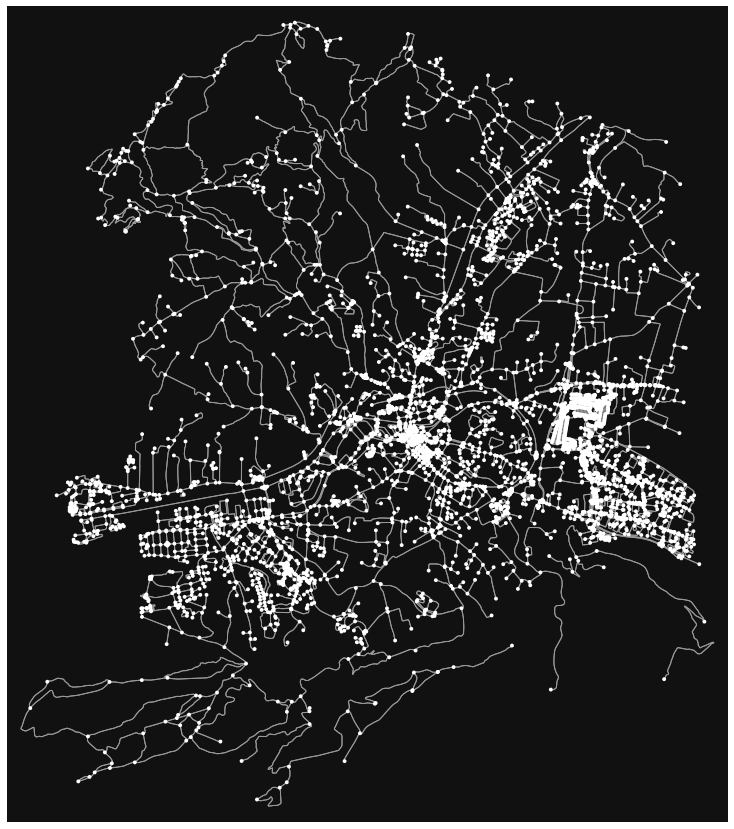

(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:>)

In [14]:
ox.plot_graph(G,figsize=(15,15))

In [16]:
GG = ox.graph_from_xml('aubagne.osm',retain_all=True)
# conversion prélable du pbf en osm (on passe de 2 à 37 Mo. à voir si on peut supprimer les relations...)
# bizarrement graph_from_xml est bcp + pauvre que les API qui vont chercher les données via overpass. Dommage!
# cf. https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_xml
# Il n'y a pas l'option network_type!
# et la lecture est assez lente

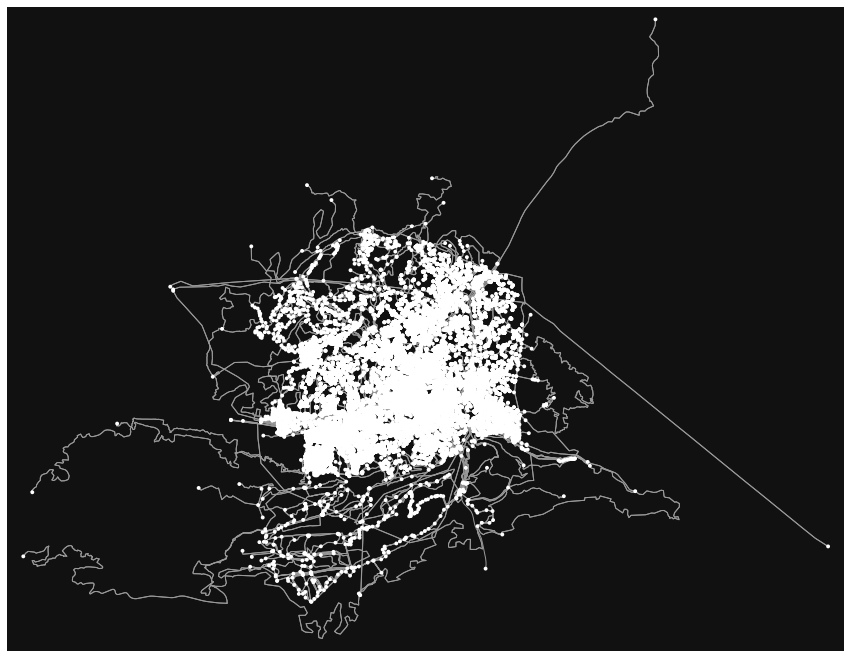

(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:>)

In [17]:
ox.plot_graph(GG,figsize=(15,15))
# on voit que le fichier .osm contient des ways qui débordent du périmètre de la commune

In [16]:
#G2 = ox.consolidate_intersections(G, tolerance=1, rebuild_graph=True, dead_ends=True)
# consolidate_intersections ne donne rien avec des paramètres par défaut, creuser la doc osmnx d'abord 
# c'est sans doute qu'il faut définir la projection du graphe, la tolérance est en mètres?
# lire cet article https://www.timlrx.com/2019/01/05/cleaning-openstreetmap-intersections-in-python/

In [31]:
# on repart avec le graphe G lu par overpass ; on commence par rendre le graphe mono-directionnel
# sinon polygonize ne marche pas
G=ox.utils_graph.get_undirected(G)
aubagne=ox.utils_graph.graph_to_gdfs(G,nodes=False,edges=True,fill_edge_geometry=True)

In [35]:
print(aubagne.columns)
# il manque quelques colonnes, par rapport à ce qui est importé par pyrosm, par exemple lit ou surface,
# mais c'est peut être configurable
print(len(aubagne.geometry))

Index(['osmid', 'ref', 'name', 'highway', 'maxspeed', 'oneway', 'length',
       'from', 'to', 'geometry', 'lanes', 'bridge', 'junction', 'service',
       'access', 'tunnel', 'width', 'u', 'v', 'key'],
      dtype='object')
5726


In [33]:
result, dangles, cuts, invalids = polygonize_full(aubagne.geometry)

In [49]:
# il faudrait regarder de + près les invalidways, les dangleways, les cutways (=impasses?)
blocks=list(result)
dangleways=list(dangles)
cutways=list(cuts)
invalidways=list(invalids)
print(len(blocks),len(dangleways),len(cutways),len(invalidways))
# https://shapely.readthedocs.io/en/stable/manual.html#spatial-analysis-methods
# Dangles are edges which have one or both ends which are not incident on another edge endpoint.
# Cut edges are connected at both ends but do not form part of polygon. 
# Invalid ring lines form rings which are invalid (bowties, etc).

1250 206 1443 15


In [37]:
ilots = gpd.GeoDataFrame(pd.DataFrame(range(1250)), geometry=blocks)
impasses = gpd.GeoDataFrame(pd.DataFrame(range(1443)), geometry=cutways)

<AxesSubplot:>

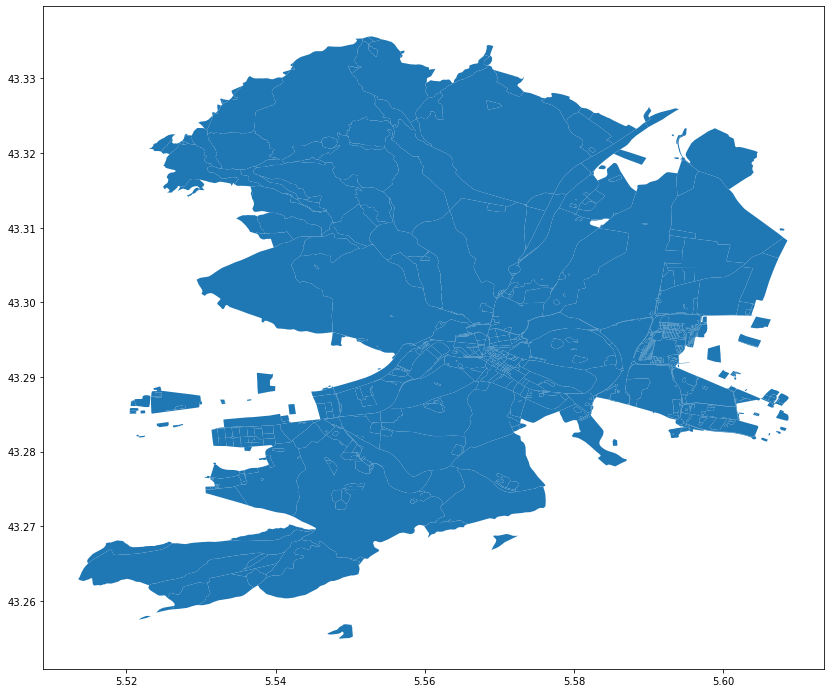

In [38]:
ilots.plot(figsize=(14,14))

<AxesSubplot:>

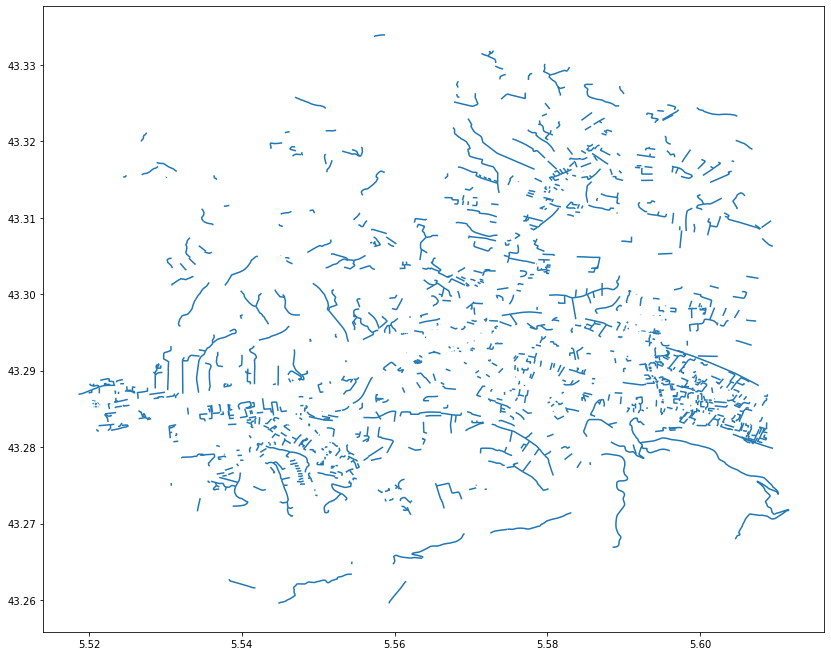

In [39]:
impasses.plot(figsize=(14,14))
# cutways ressemble aux impasses :-)

<AxesSubplot:>

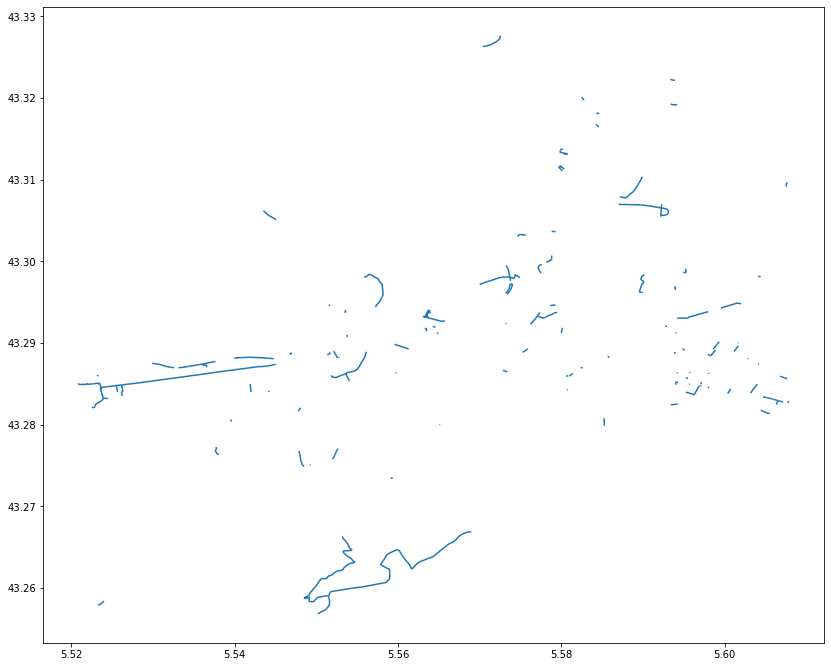

In [48]:
ways_dangles=gpd.GeoDataFrame(pd.DataFrame(range(206)), geometry=dangleways)
ways_dangles.plot(figsize=(14,14))

<AxesSubplot:>

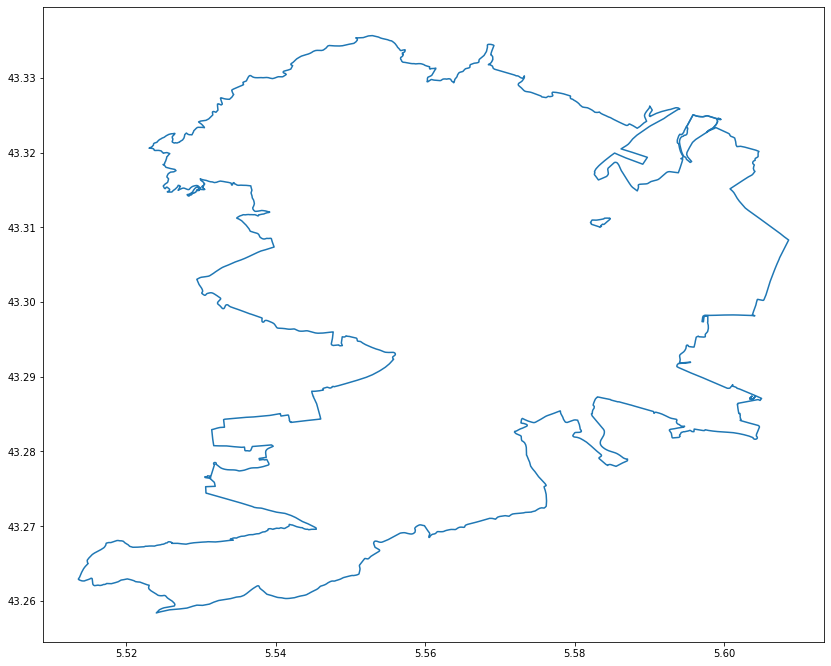

In [47]:
ways_invalides=gpd.GeoDataFrame(pd.DataFrame(range(15)), geometry=invalidways)
ways_invalides.plot(figsize=(14,14))
# bizarrement on a dans les invalid ways visiblement la limite communale??